<a href="https://colab.research.google.com/github/tinayiluo0322/XAI_Projects/blob/main/Object_Detection_Yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #05
### Explainable_ML_I
### Luopeiwen Yi

## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [1]:
# import os

# # Remove Colab default sample_data if it exists
# if os.path.isdir("./sample_data"):
#     !rm -r ./sample_data

# # Clone GitHub repo (force re-clone if it already exists)
# repo_name = "XAI_Projects"
# git_path = 'https://github.com/tinayiluo0322/XAI_Projects.git'

# if os.path.isdir(repo_name):
#     !rm -rf "{repo_name}"
# !git clone "{git_path}"

# # Install dependencies from requirements.txt if it exists
# #requirements_file = os.path.join(repo_name, 'requirements.txt')
# #if os.path.isfile(requirements_file):
#     #!pip install -r "{requirements_file}"
# #else:
#     #print("No requirements.txt found, skipping dependency installation.")

# # Change working directory to location of notebook
# notebook_dir = 'Explainable_ML_I'
# path_to_notebook = os.path.join(repo_name, notebook_dir)

# # Check if the directory exists
# if os.path.isdir(path_to_notebook):
#     %cd "{path_to_notebook}"
#     %ls
# else:
#     print(f"Directory {path_to_notebook} not found")

In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [3]:
import os
import shutil
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import json
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from IPython.display import Image, display
!pip install Pillow
import cv2
from google.colab.patches import cv2_imshow
!pip install shap
import shap
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
!pip install alibi
from alibi.explainers import AnchorImage
from google.colab import output
output.enable_custom_widget_manager()
from google.colab import drive
import os
import torch
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import json
import random

import torch
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import cv2
!pip install utils
from utils.general import non_max_suppression, box_iou

Check GPU Availability

In [4]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using device: cuda
Using GPU: NVIDIA L4


Access Original KITTI Training Data

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the path to the KITTI dataset folder in Google Drive
dataset_path = '/content/drive/MyDrive/KITTI_Dataset/'

# List the files in the dataset folder to confirm upload
if os.path.isdir(dataset_path):
    print(f"Dataset directory contents: {os.listdir(dataset_path)}")
else:
    print(f"Directory {dataset_path} not found")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory contents: ['original_training', 'class_mapping.json', 'sample_detection']


Pre-trained YoloV5

Since We are just using the pre-trained YoloV5, we are going to directly test it's performance on the smaple images from the KITTI's original training dataset.

In [6]:
# Load the pretrained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)

# Set model to evaluation mode
model.eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 48, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  

Sample 1 Image

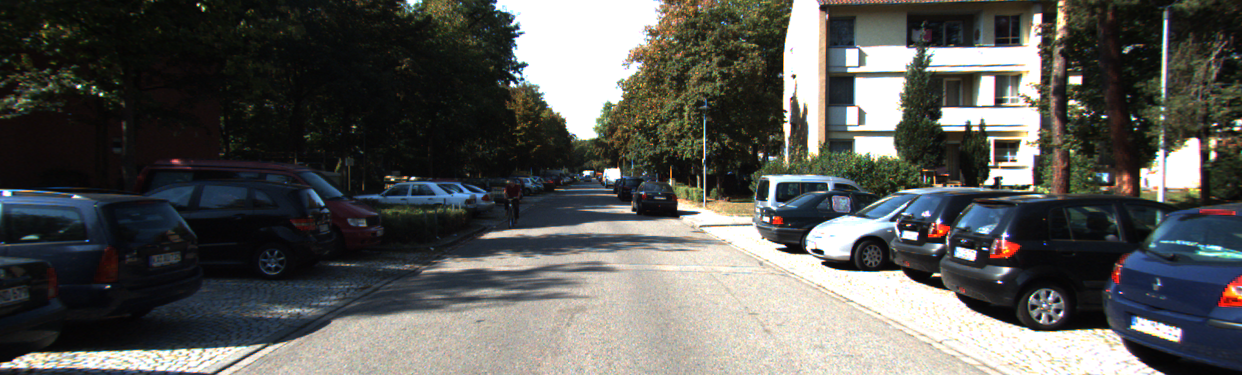

In [7]:
# Load the image using OpenCV
image_path_007480 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png'
image_007480 = cv2.imread(image_path_007480)

# Display the image
cv2_imshow(image_007480)

In [8]:
# Convert the image to a PyTorch format using model input processing
results_007480 = model(image_007480)

WARNING ⚠️ NMS time limit 0.550s exceeded


In [9]:
# Run the detection on a sample image with custom output location
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source /content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png --project /content/drive/MyDrive/KITTI_Dataset/sample_detection --name yolov5_results --exist-ok

detect: weights=['yolov5s.pt'], source=/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/KITTI_Dataset/sample_detection, name=yolov5_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png: 224x640 1 person, 18 cars, 43.6ms
Speed: 0.4ms pre-process, 43.6ms inference, 591.

In [10]:
# List all files in the detection result folder to find the correct image
output_dir = '/content/drive/MyDrive/KITTI_Dataset/sample_detection/yolov5_results'
print(os.listdir(output_dir))

['007480.png', '000015.png']


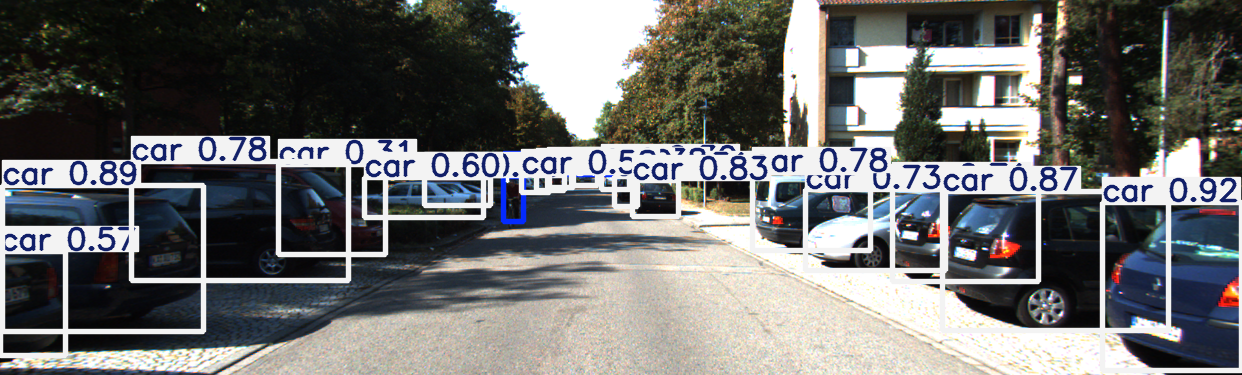

In [11]:
# Update the path to the correct folder where YOLOv5 saved the detection results
display(Image(filename='/content/drive/MyDrive/KITTI_Dataset/sample_detection/yolov5_results/007480.png'))

Sample 2 Image

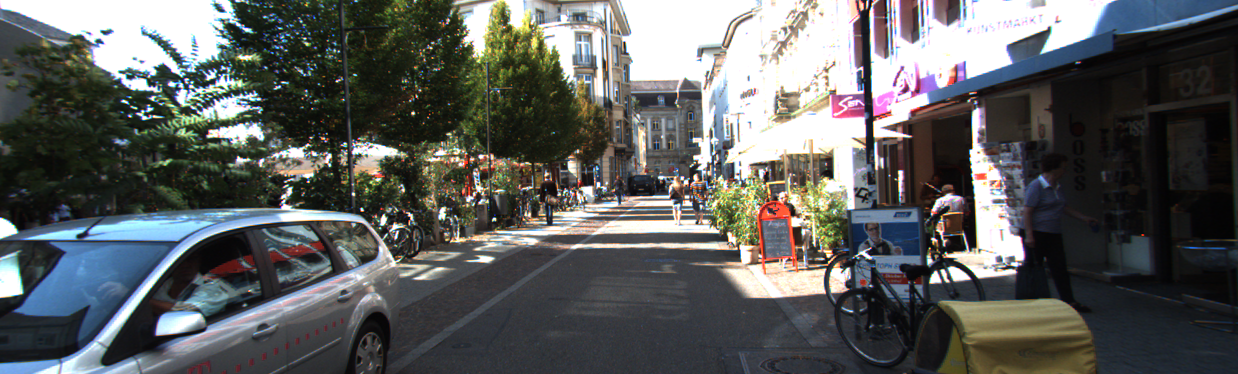

In [12]:
# Load the image using OpenCV
image_path_000015 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/000015.png'
image_000015 = cv2.imread(image_path_000015)

# Display the image
cv2_imshow(image_000015)

In [13]:
# Convert the image to a PyTorch format using model input processing
results_000015 = model(image_000015)

In [14]:
# Run the detection on a sample image with custom output location
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source /content/drive/MyDrive/KITTI_Dataset/original_training/training_images/000015.png --project /content/drive/MyDrive/KITTI_Dataset/sample_detection --name yolov5_results --exist-ok

detect: weights=['yolov5s.pt'], source=/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/000015.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/KITTI_Dataset/sample_detection, name=yolov5_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/KITTI_Dataset/original_training/training_images/000015.png: 224x640 6 persons, 3 bicycles, 1 car, 1 potted plant, 44.2ms
Speed: 0.4ms pre-proc

In [15]:
# List all files in the detection result folder to find the correct image
output_dir = '/content/drive/MyDrive/KITTI_Dataset/sample_detection/yolov5_results'
print(os.listdir(output_dir))

['007480.png', '000015.png']


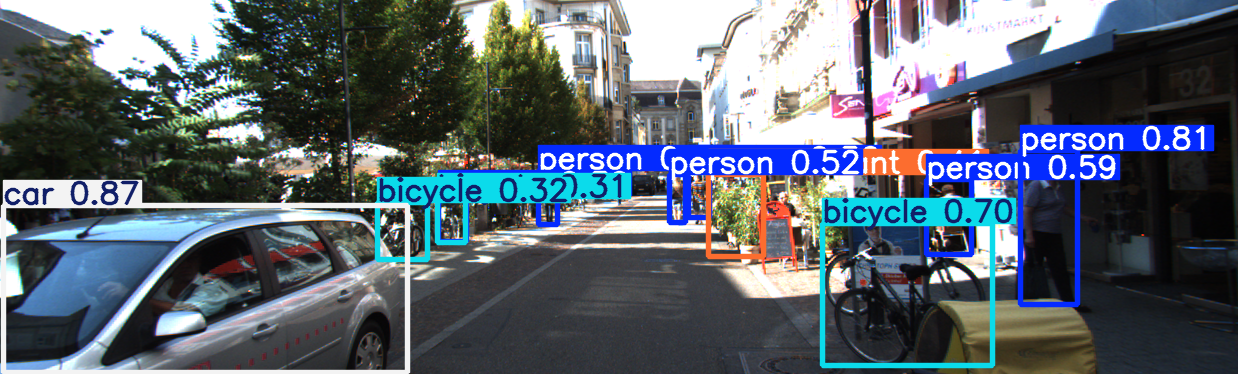

In [16]:
# Update the path to the correct folder where YOLOv5 saved the detection results
display(Image(filename='/content/drive/MyDrive/KITTI_Dataset/sample_detection/yolov5_results/000015.png'))

SHAP Explaination

YOLOv5 Internal Preprocessing:

When you use YOLOv5 for detection (e.g., using the command line or PyTorch hub), YOLOv5 internally handles many preprocessing tasks for you, such as:

Resizing the input image to its expected size (e.g., 640x640).
Normalizing the image and converting it into the correct tensor format ([batch_size, channels, height, width]).
This internal handling simplifies the process, so when you pass an image for detection, YOLOv5 automatically takes care of these steps. Thus, you didn’t need to worry about manually resizing or converting the image to a tensor when performing detection.

SHAP and Model Input:

SHAP, on the other hand, interacts directly with the model you pass it, meaning you need to ensure the input format matches what the model expects. SHAP doesn’t automatically handle the preprocessing steps YOLOv5 does internally. Therefore, you need to:

Resize the image to match the YOLOv5 input size (640x640).
Convert the image into a PyTorch tensor in the correct shape ([1, 3, 640, 640]).
Without doing these preprocessing steps manually, the image will not have the correct dimensions and format that YOLOv5 expects, which causes the errors you're encountering when SHAP tries to run explanations on the model.

Why is the Step Necessary for SHAP?

No Automatic Preprocessing: SHAP doesn’t handle image preprocessing (resizing, tensor conversion) for you, whereas YOLOv5 does this internally when you pass an image for prediction.

Correct Tensor Format: SHAP needs the input to match what YOLOv5 expects for making predictions, meaning it needs the image in the format [batch_size, channels, height, width] (i.e., 1, 3, 640, 640 for a single RGB image).

To Summarize:
YOLOv5: Automatically resizes and processes images for prediction.
SHAP: You need to manually handle the preprocessing to match what YOLOv5 expects (resizing to 640x640 and converting to tensor format).

Why SHAP Might Be a Better Alternative:

SHAP (SHapley Additive exPlanations) provides a more robust framework for explaining complex models like object detection models. It doesn't require making as many simplifications as LIME does.

SHAP works by assigning each feature an importance value based on how it contributes to the model’s prediction, which can be more intuitive for models that handle variable-length outputs (like YOLOv5’s bounding boxes).

SHAP is also better at handling non-standard prediction outputs, like YOLOv5’s object detection, because it provides exact solutions for the importance of each feature (or area of the image, in this case).

Key Benefits of SHAP:

Consistent Output: SHAP provides a more accurate and granular understanding of how each part of an image contributes to the model's prediction.

No Simplifications: SHAP doesn't require artificial truncation of the output to fit a fixed number of classes or detections. It’s inherently better suited to models like YOLOv5, which produce variable-length outputs (such as bounding boxes and confidence scores).

Better Interpretability: SHAP is based on Shapley values from game theory, which provide a mathematically sound way to assign importance to each feature, making the explanation more interpretable.

Conclusion:

LIME requires truncating outputs, which might limit interpretability, particularly for object detection models like YOLOv5.

SHAP provides a better alternative for explaining models like YOLOv5, as it doesn't force you to simplify outputs and provides more nuanced explanations.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


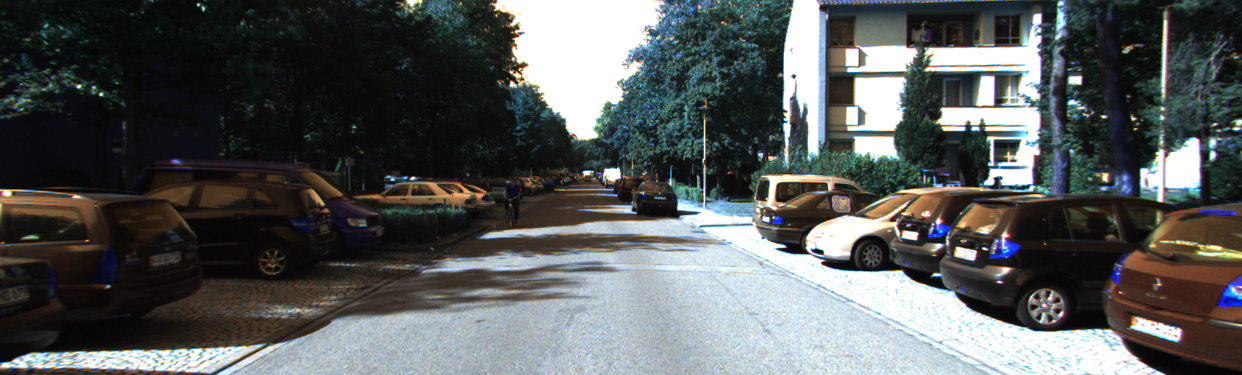

Image dimensions: height=375, width=1242


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 
image 1/1: 375x1242 1 person, 17 cars
Speed: 1.5ms pre-process, 10.6ms inference, 1.8ms NMS per image at shape (1, 3, 224, 640)


IndexError: tuple index out of range

In [19]:
# Mount Google Drive
from google.colab import drive
import os
import torch
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random

# Mount Google Drive
drive.mount('/content/drive')

# Device handling (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load your KITTI image from Google Drive
image_path_007480 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png'
image_007480 = cv2.imread(image_path_007480)
image_007480_rgb = cv2.cvtColor(image_007480, cv2.COLOR_BGR2RGB)

# Display the original image to ensure it's loaded correctly
cv2_imshow(image_007480_rgb)

# Get the dimensions of the image
height, width = image_007480_rgb.shape[:2]
print(f"Image dimensions: height={height}, width={width}")

# Load the YOLOv5 model (medium model)
model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)
model.to(device)
model.eval()

# Run YOLOv5 inference on the image
results_007480 = model(image_007480_rgb)
results_007480.print()  # Print detected objects

# Get the bounding box and class for the target object (assuming the first object for now)
output = results_007480.xyxy  # This will give bounding boxes, classes, and confidence
target_index = 0  # You can adjust based on the object of interest
target = output[0][target_index].cpu().numpy()  # Extract the target bounding box

# Define the CastNumpy class for conversion to PyTorch format
class CastNumpy(torch.nn.Module):
    def __init__(self):
        super(CastNumpy, self).__init__()

    def forward(self, image):
        image = np.ascontiguousarray(image)
        image = torch.from_numpy(image).to(device)
        if image.ndimension() == 3:
            image = image.unsqueeze(0)  # Add batch dimension
        image_half = image.half()  # Convert to half precision for memory optimization
        return image_half

# Instantiate the CastNumpy converter
numpy2torch_converter = CastNumpy()

class OD2Score(torch.nn.Module):
    def __init__(self, target, conf_thresh=0.01, iou_thresh=0.5):
        super(OD2Score, self).__init__()
        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh
        self.target = torch.tensor(target, device=device)

    def forward(self, x):
        score_best_box = torch.zeros([x[0].shape[0]], device=device)
        for idx, img in enumerate(x[0]):
            img = img.unsqueeze(0)

            # Check if the prediction is empty
            if img.numel() == 0:
                print(f"Empty prediction for image {idx}.")
                continue

            # Run non_max_suppression with confidence and IoU thresholds
            output = non_max_suppression(img, conf_thres=self.conf_thresh, iou_thres=self.iou_thresh)

            # Check if output is empty or has no valid detections
            if not output or len(output[0]) == 0:
                print(f"No valid detections for image {idx}.")
                continue

            correct_class_predictions = output[0][..., 5] == self.target[5]
            correctly_labeled_boxes = output[0][correct_class_predictions]

            if correctly_labeled_boxes.shape[0]:
                iou_with_target, _idx = box_iou(correctly_labeled_boxes[:, :4], self.target.unsqueeze(0)[:, :4]).max(1)
                index_best_box_in_correct_class = torch.argmax(iou_with_target)
                index_best_box_in_output = torch.where(output[0][..., 5] == self.target[5])[0][index_best_box_in_correct_class]

                # Score for the detection is a product of the object confidence and IoU
                score_best_box[idx] = output[0][index_best_box_in_output][4] * iou_with_target[index_best_box_in_correct_class]

        return score_best_box.cpu().numpy()

# Update the super_pixel_model definition
super_pixel_model = torch.nn.Sequential(
    super_pixler,
    numpy2torch_converter,
    model,
    scoring
)

# Evaluate the image with different parts occluded using super-pixels
try:
    score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)]]))  # Fully occluded image
    print(score, "# score for whole image occluded")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("This might be due to no detections in the fully occluded image, which is expected behavior.")

# Instantiate the OD2Score object
scoring = OD2Score(target, conf_thresh=0.25, iou_thresh=0.5)

# Define the SuperPixler class to apply super-pixels for explainability
class SuperPixler(torch.nn.Module):
    def __init__(self, image, super_pixel_width):
        super(SuperPixler, self).__init__()
        self.image = image.transpose(2, 0, 1)  # Convert to PyTorch format (C, H, W)
        self.mean_color = self.image.mean()  # Calculate mean color for occlusion
        self.image = np.expand_dims(self.image, axis=0)
        self.image_height = image.shape[0]
        self.image_width = image.shape[1]
        self.super_pixel_width = super_pixel_width

    def forward(self, mask):
        """
        In the forward step we accept the super-pixel masks and transform them to a batch of images.
        """
        pixeled_image = np.repeat(self.image.copy(), mask.shape[0], axis=0)
        for i, super_pixel in enumerate(mask.T):
            images_to_pixelate = [bool(p) for p in super_pixel]

            # Determine the x and y coordinates for the super-pixel
            x_coord = (i * self.super_pixel_width // self.image_width) * self.super_pixel_width
            y_coord = (i * self.super_pixel_width % self.image_width)

            # Apply the mean color to the selected super-pixels
            pixeled_image[images_to_pixelate, :, x_coord:x_coord + self.super_pixel_width, y_coord:y_coord + self.super_pixel_width] = self.mean_color
        return pixeled_image

# Set the super-pixel width and calculate the total number of super-pixels
super_pixel_width = 16

# ** Pad the image to ensure dimensions are divisible by super_pixel_width **
pad_x = (super_pixel_width - width % super_pixel_width) % super_pixel_width
pad_y = (super_pixel_width - height % super_pixel_width) % super_pixel_width

# Pad the image (padding on the right and bottom)
image_007480_rgb_padded = cv2.copyMakeBorder(image_007480_rgb, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=[0, 0, 0])

# Adjust new dimensions after padding
height_padded, width_padded = image_007480_rgb_padded.shape[:2]

# Calculate the number of super-pixels along x and y for the padded image
n_super_pixel_x = width_padded // super_pixel_width
n_super_pixel_y = height_padded // super_pixel_width
n_super_pixel = n_super_pixel_x * n_super_pixel_y  # Total number of super-pixels

# Generate masks with consistent shape
mask_1 = [1 for _ in range(n_super_pixel)]  # Fully occluded image
mask_2 = [random.randint(0, 1) for _ in range(n_super_pixel)]  # Random occlusion of super-pixels

# Ensure the masks have exactly n_super_pixel elements
if len(mask_1) < n_super_pixel:
    mask_1 += [0] * (n_super_pixel - len(mask_1))  # Pad mask_1 if it's too short
if len(mask_2) < n_super_pixel:
    mask_2 += [0] * (n_super_pixel - len(mask_2))  # Pad mask_2 if it's too short

# Now, convert the masks to a NumPy array with a consistent shape
mask = np.array([mask_1, mask_2])

# Instantiate the SuperPixler object with the padded image
super_pixler = SuperPixler(image_007480_rgb_padded, super_pixel_width=super_pixel_width)

# Pass the mask to the SuperPixler forward method
img_s = super_pixler.forward(mask)

# Visualize the super-pixellated images
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Image fully occluded by super pixels")
ax1.imshow(img_s[0, :, :, :].transpose(1, 2, 0))

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Image randomly occluded by super pixels")
ax2.imshow(img_s[1, :, :, :].transpose(1, 2, 0))
plt.show()

# Create the sequential model for explainability using super-pixels
super_pixel_model = torch.nn.Sequential(
    super_pixler,
    numpy2torch_converter,
    model,
    scoring
)

# Evaluate the image with different parts occluded using super-pixels
score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)]]))  # Fully occluded image
print(score, "# score for whole image occluded")

In [22]:
# Define the super-pixel width
super_pixel_width = 16

# Load the KITTI image
image_path_007480 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png'
img = cv2.imread(image_path_007480)  # Load the image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Get the dimensions of the image
height, width = img.shape[:2]

# Calculate the padding needed to make the width and height divisible by super_pixel_width
pad_x = (super_pixel_width - width % super_pixel_width) % super_pixel_width
pad_y = (super_pixel_width - height % super_pixel_width) % super_pixel_width

# Apply padding to the image (padding at the bottom and right sides)
img_padded = cv2.copyMakeBorder(img, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=[0, 0, 0])

# Update the dimensions of the padded image
height_padded, width_padded = img_padded.shape[:2]

print(f"Original image size: {width}x{height}")
print(f"Padded image size: {width_padded}x{height_padded}")

# Define the CastNumpy class for converting images to tensors
class CastNumpy(torch.nn.Module):
    def __init__(self):
        super(CastNumpy, self).__init__()

    def forward(self, image):
        image = np.ascontiguousarray(image)
        image = torch.from_numpy(image).to(device)
        if image.ndimension() == 3:
            image = image.unsqueeze(0)
        image_half = image.half()
        return image_half

# Instantiate the numpy to torch converter
numpy2torch_converter = CastNumpy()

# Define the OD2Score class for scoring YOLOv5 predictions
class OD2Score(torch.nn.Module):
    def __init__(self, target, conf_thresh=0.01, iou_thresh=0.5):
        super(OD2Score, self).__init__()
        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh
        self.target = torch.tensor(target, device=device)

    def forward(self, x):
        score_best_box = torch.zeros([x[0].shape[0]], device=device)

        for idx, img in enumerate(x[0]):
            img = img.unsqueeze(0)
            output = non_max_suppression(img, conf_thres=self.conf_thresh, iou_thres=self.iou_thresh)
            if output and output[0] is not None:
                correct_class_predictions = output[0][..., 5] == self.target[5]
                correctly_labeled_boxes = output[0][correct_class_predictions]
                if correctly_labeled_boxes.shape[0]:
                    iou_with_target, _idx = box_iou(correctly_labeled_boxes[:, :4], self.target.unsqueeze(0)[:, :4]).max(1)
                    index_best_box_in_correct_class = torch.argmax(iou_with_target)
                    index_best_box_in_output = torch.where(output[0][..., 5] == self.target[5])[0][index_best_box_in_correct_class]
                    score_best_box[idx] = output[0][index_best_box_in_output][4] * iou_with_target[index_best_box_in_correct_class]

        return score_best_box.cpu().numpy()

# Assuming your YOLOv5 model is loaded and inference has been run to obtain the target object
target_index = 0  # Adjust this as necessary
target = output[0].cpu().numpy()[target_index, :]  # Assuming output contains predictions

# Instantiate OD2Score for your scenario
scoring = OD2Score(target, conf_thresh=0.25, iou_thresh=0.5)

# Define the SuperPixler class
class SuperPixler(torch.nn.Module):
    def __init__(self, image, super_pixel_width):
        super(SuperPixler, self).__init__()
        self.image = image.transpose(2, 0, 1)  # Convert to PyTorch format (C, H, W)
        self.mean_color = self.image.mean()
        self.image = np.expand_dims(self.image, axis=0)
        self.image_width = image.shape[1]
        self.super_pixel_width = super_pixel_width

    def forward(self, x):
        pixeled_image = np.repeat(self.image.copy(), x.shape[0], axis=0)
        for i, super_pixel in enumerate(x.T):
            images_to_pixelate = [bool(p) for p in super_pixel]
            x_coord = (i * self.super_pixel_width // self.image_width) * self.super_pixel_width
            y_coord = (i * self.super_pixel_width % self.image_width)
            pixeled_image[images_to_pixelate, :, x_coord:x_coord + self.super_pixel_width, y_coord:y_coord + self.super_pixel_width] = self.mean_color
        return pixeled_image

# Set up the super-pixel width and number of super-pixels
super_pixel_width = 16

# Ensure the padded image dimensions are used
assert (width_padded / super_pixel_width) % 1 == 0, "Padded image width needs to be a multiple of super-pixel width"
n_super_pixel = int((width_padded / super_pixel_width) ** 2)

# Instantiate SuperPixler with the padded image
super_pixler = SuperPixler(img_padded, super_pixel_width=super_pixel_width)

# Test the pipeline with some super-pixel masks
mask_1 = [1 for _ in range(n_super_pixel // 2)] + [0 for _ in range(n_super_pixel // 2)]  # Example mask
mask_2 = [random.randint(0, 1) for _ in range(n_super_pixel)]  # Random occlusion

# Pass the masks through the SuperPixler
img_s = super_pixler.forward(np.array([mask_1, mask_2]))

Original image size: 1242x375
Padded image size: 1248x384


In [25]:
# Convert img_s from torch Tensor to numpy and ensure proper scaling
img_s_np = img_s.numpy()  # Convert to NumPy if it is a PyTorch tensor

# If img_s is in the range [0, 1], rescale to [0, 255]
if img_s_np.max() <= 1.0:
    img_s_np *= 255

# Ensure data type is uint8 for visualization
img_s_np = img_s_np.astype(np.uint8)

# Visualize the result
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

# Transpose from (C, H, W) to (H, W, C)
ax[0].imshow(img_s_np[0, :, :, :].transpose(1, 2, 0))
ax[0].set_title("Super-pixel occlusion 1")

ax[1].imshow(img_s_np[1, :, :, :].transpose(1, 2, 0))
ax[1].set_title("Super-pixel occlusion 2")

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
# # Load the image using OpenCV
# image_path_007480 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png'
# image_007480 = cv2.imread(image_path_007480)  # Open image as BGR format (default in OpenCV)

# # Convert the image from BGR (OpenCV format) to RGB (expected by YOLOv5)
# image_007480 = cv2.cvtColor(image_007480, cv2.COLOR_BGR2RGB)

# # Resize the image to the expected size (640x640)
# image_007480 = cv2.resize(image_007480, (640, 640))

# # Convert the image to a NumPy array and then to a PyTorch tensor with correct dimensions [1, 3, 640, 640]
# image_007480_np = np.array(image_007480)
# image_tensor_007480 = torch.tensor(image_007480_np).permute(2, 0, 1).unsqueeze(0).float()  # Permute to [C, H, W] and add batch dimension

In [ ]:
# # Set requires_grad to True for SHAP to compute gradients
# image_tensor_007480.requires_grad = True

# # Move the tensor to the correct device (GPU/CPU)
# image_tensor_007480 = image_tensor_007480.to(device)

# # Ensure the model is in training mode and can compute gradients
# model.train()

In [ ]:
# # Initialize the SHAP DeepExplainer
# explainer = shap.DeepExplainer(model, image_tensor_007480)

# # Generate SHAP values
# shap_values = explainer.shap_values(image_tensor_007480)

# # Visualize SHAP values
# shap.image_plot(shap_values, np.array([image_007480_np]))

https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html

https://www.steadforce.com/how-tos/explainable-object-detection


In [ ]:
# # Load the image using OpenCV
# image_path_007480 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png'
# image_007480 = cv2.imread(image_path_007480)  # Open image as BGR format (default in OpenCV)

# # Convert the image from BGR (OpenCV format) to RGB (expected by YOLOv5)
# image_007480 = cv2.cvtColor(image_007480, cv2.COLOR_BGR2RGB)

# # Resize the image to the expected size (640x640)
# image_007480 = cv2.resize(image_007480, (640, 640))

# # Convert the image to a NumPy array
# image_007480_np = np.array(image_007480)

# # Custom prediction function for SHAP KernelExplainer
# def custom_predict(images):
#     images = torch.tensor(images).permute(0, 3, 1, 2).float()  # Convert to PyTorch tensors and permute to [B, C, H, W]
#     images = images.to(device)

#     # Run the images through the YOLOv5 model
#     outputs = model(images)

#     # Extract the confidence scores for the predictions
#     confidence_scores = []
#     for output in outputs:  # Loop over batch
#         if len(output) > 0:
#             # Extract confidence scores from the 5th position in each detection
#             confidence_scores.append(output[:, 4].cpu().detach().numpy())  # Take the confidence score
#         else:
#             confidence_scores.append([0])  # If no detections, return 0 confidence score

#     # Convert to numpy array and reshape to fit SHAP's requirements
#     return np.array(confidence_scores).reshape(-1, 1)

# # Initialize the SHAP KernelExplainer
# explainer = shap.KernelExplainer(custom_predict, np.array([image_007480_np]))

# # Generate SHAP values for the image
# shap_values = explainer.shap_values(image_007480_np)

# # Visualize SHAP values
# shap.image_plot(shap_values, np.array([image_007480_np]))

In [ ]:
# # Load the image using OpenCV
# image_path_007480 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png'
# image_007480 = cv2.imread(image_path_007480)  # Open image as BGR format (default in OpenCV)

# # Convert the image from BGR (OpenCV format) to RGB (expected by YOLOv5)
# image_007480 = cv2.cvtColor(image_007480, cv2.COLOR_BGR2RGB)

# # Resize the image to the expected size (640x640)
# image_007480 = cv2.resize(image_007480, (640, 640))

# # Convert the image to a NumPy array
# image_007480_np = np.array(image_007480)

# # Reshape the image to 1D for SHAP KernelExplainer (flattening the image)
# image_007480_flattened = image_007480_np.reshape(-1)

# # Custom prediction function for SHAP KernelExplainer
# def custom_predict(images):
#     # Reshape images back to [B, C, H, W] for YOLOv5
#     images = [img.reshape(640, 640, 3) for img in images]  # Reshape back from 1D to [H, W, C]
#     images = [torch.tensor(img).permute(2, 0, 1).float().unsqueeze(0) for img in images]  # Convert to PyTorch tensors and permute to [B, C, H, W]
#     images = torch.cat(images).to(device)

#     # Run the images through the YOLOv5 model
#     outputs = model(images)

#     # Extract the confidence scores for the predictions
#     confidence_scores = []
#     for output in outputs:  # Loop over batch
#         if len(output) > 0:
#             # Extract confidence scores from the 5th position in each detection
#             confidence_scores.append(output[:, 4].cpu().detach().numpy())  # Take the confidence score
#         else:
#             confidence_scores.append([0])  # If no detections, return 0 confidence score

#     # Convert to numpy array and reshape to fit SHAP's requirements
#     return np.array(confidence_scores).reshape(-1, 1)

# # Initialize the SHAP KernelExplainer
# explainer = shap.KernelExplainer(custom_predict, image_007480_flattened)

# # Generate SHAP values for the flattened image
# shap_values = explainer.shap_values(image_007480_flattened)

# # Visualize SHAP values (reshape SHAP values back to original image dimensions for visualization)
# shap_values_reshaped = np.array(shap_values).reshape(640, 640, 3)
# shap.image_plot([shap_values_reshaped], [image_007480_np])

In [ ]:
import cv2
import numpy as np
import shap
import torch
import matplotlib.pyplot as plt

# Load the image using OpenCV
image_path_007480 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png'
image_007480 = cv2.imread(image_path_007480)

# Convert the image from BGR (OpenCV format) to RGB (expected by YOLOv5)
image_007480 = cv2.cvtColor(image_007480, cv2.COLOR_BGR2RGB)

# Resize the image to the expected size (640x640)
image_007480 = cv2.resize(image_007480, (640, 640))

# Convert the image to a NumPy array
image_007480_np = np.array(image_007480)

# Reshape the image to 2D for SHAP KernelExplainer (flatten the image)
image_007480_flattened = image_007480_np.reshape(1, -1)

# Custom prediction function for SHAP KernelExplainer
def custom_predict(images):
    # Reshape images back to [B, C, H, W] for YOLOv5
    images = [img.reshape(640, 640, 3) for img in images]
    images = [torch.tensor(img).permute(2, 0, 1).float().unsqueeze(0) for img in images]
    images = torch.cat(images).to(device)

    # Run the images through the YOLOv5 model
    outputs = model(images)

    # Extract the confidence scores for the predictions
    confidence_scores = []
    for output in outputs:
        if len(output) > 0:
            confidence_scores.append(output[:, 4].cpu().detach().numpy())
        else:
            confidence_scores.append([0])

    return np.array(confidence_scores).reshape(-1, 1)

# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(custom_predict, image_007480_flattened)

# Generate SHAP values for the flattened image
shap_values = explainer.shap_values(image_007480_flattened)

# Reshape SHAP values back to original image dimensions for visualization
shap_values_reshaped = np.array(shap_values).reshape(640, 640, 3)

# Display the SHAP values
shap.image_plot(shap_values_reshaped, image_007480_np)

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the original image
ax1.imshow(image_007480_np)
ax1.set_title('Original Image')
ax1.axis('off')

# Plot the SHAP values
shap_img = ax2.imshow(np.sum(np.abs(shap_values_reshaped), axis=-1), cmap='viridis')
ax2.set_title('SHAP Values (Summed Absolute Values)')
ax2.axis('off')

# Add a colorbar to the SHAP plot
plt.colorbar(shap_img, ax=ax2, label='SHAP Value Magnitude')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# You can also still try the shap.image_plot function
try:
    shap.image_plot(shap_values_reshaped, image_007480_np)
except Exception as e:
    print(f"shap.image_plot failed with error: {e}")
    print("But we've provided an alternative visualization above.")

In [ ]:
import cv2
import numpy as np
import shap
import torch
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path_007480 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png'
image_007480 = cv2.imread(image_path_007480)
image_007480 = cv2.cvtColor(image_007480, cv2.COLOR_BGR2RGB)
image_007480 = cv2.resize(image_007480, (640, 640))
image_007480_np = np.array(image_007480)
image_007480_flattened = image_007480_np.reshape(1, -1)

# Print shape information for debugging
print("Image shape:", image_007480_np.shape)
print("Flattened image shape:", image_007480_flattened.shape)

# Assuming you have already defined and loaded your model and computed shap_values
# If not, you need to do that here

# Print SHAP values information
print("SHAP values shape:", shap_values_reshaped.shape)
print("SHAP values min:", np.min(shap_values_reshaped))
print("SHAP values max:", np.max(shap_values_reshaped))

# Ensure we're in inline plotting mode for Jupyter notebooks
%matplotlib inline

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the original image
ax1.imshow(image_007480_np)
ax1.set_title('Original Image')
ax1.axis('off')

# Plot the SHAP values
shap_sum = np.sum(np.abs(shap_values_reshaped), axis=-1)
shap_img = ax2.imshow(shap_sum, cmap='viridis')
ax2.set_title('SHAP Values (Summed Absolute Values)')
ax2.axis('off')

# Add a colorbar to the SHAP plot
plt.colorbar(shap_img, ax=ax2, label='SHAP Value Magnitude')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# If the above doesn't work, try saving the figure
plt.savefig('shap_visualization.png')
print("Figure saved as 'shap_visualization.png'")

# Alternative: Plot using directly matplotlib
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(image_007480_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(shap_sum, cmap='viridis')
plt.title('SHAP Values (Summed Absolute Values)')
plt.axis('off')
plt.colorbar(label='SHAP Value Magnitude')

plt.tight_layout()
plt.show()

# Try the shap.image_plot function
try:
    shap.image_plot(shap_values_reshaped, image_007480_np)
except Exception as e:
    print(f"shap.image_plot failed with error: {e}")
    print("But we've provided alternative visualizations above.")

Anchor

https://docs.seldon.io/projects/alibi/en/latest/api/alibi.explainers.anchors.anchor_image.html

In [ ]:
from alibi.explainers import AnchorImage
import cv2
import torch
import numpy as np

# Load and preprocess the image
image_path_007480 = '/content/drive/MyDrive/KITTI_Dataset/original_training/training_images/007480.png'
image_007480 = cv2.imread(image_path_007480)  # Open image as BGR format (default in OpenCV)

# Convert the image from BGR (OpenCV format) to RGB (expected by YOLOv5)
image_007480 = cv2.cvtColor(image_007480, cv2.COLOR_BGR2RGB)

# Resize the image to the expected size (640x640)
image_007480 = cv2.resize(image_007480, (640, 640))

# Convert the image to a NumPy array
image_007480_np = np.array(image_007480)

# Custom prediction function for YOLOv5 (to be used with Anchor)
def custom_predict_anchors(images):
    # Convert images to tensors and move them to the device
    images = [torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) for img in images]
    images = torch.cat(images, dim=0)  # Stack images along batch dimension

    # Run the images through the YOLOv5 model
    with torch.no_grad():
        results = model(images)

    class_probs = []
    for result in results:
        detections = result[:, 4].cpu().numpy() if len(result) > 0 else np.array([0])  # Get confidence scores
        class_probs.append(detections)

    # Return as an array (ensure it's in the format AnchorImage expects)
    return np.array(class_probs)

# Initialize the Anchor Image Explainer
explainer = AnchorImage(predictor=custom_predict_anchors, image_shape=(640, 640, 3), seed=42)

# Set Anchor explainer parameters
segments_kwargs = {'n_segments': 10, 'compactness': 10, 'sigma': 0.5}

# Generate Anchor explanations for the image
explanation = explainer.explain(image_007480_np, threshold=0.95, segmentation_fn_params=segments_kwargs)

In [ ]:
# Function to visualize the explanation
def visualize_anchor_explanation(explainer, explanation, image):
    print("Image shape:", image.shape)

    # Step 1: Generate superpixels for the image
    segments = explainer.generate_superpixels(image)
    print("Segments shape:", segments.shape)

    # Step 2: Extract the superpixel mask for the explanation
    mask_features = explanation['anchor']
    print("Mask features:", mask_features)

    # Step 3: Create a 2D mask where selected superpixels are set to 1
    mask = np.zeros(segments.shape[:2], dtype=np.uint8)  # Ensure mask is 2D
    for f in mask_features:
        mask[segments == f] = 1

    print("Mask shape:", mask.shape)

    # Step 4: Expand the mask to match the RGB channels (H, W, 3)
    mask_expanded = np.expand_dims(mask, axis=-1)
    mask_expanded = np.repeat(mask_expanded, 3, axis=-1)
    print("Expanded mask shape:", mask_expanded.shape)

    # Step 5: Scale the original image for visualization
    scaled_image = explainer.scale_image(image)
    print("Scaled image shape:", scaled_image.shape)

    # Step 6: Apply the mask to the scaled image
    anchor_image = (scaled_image * mask_expanded).astype(np.uint8)

    # Plot the original image and anchor mask overlay
    plt.figure(figsize=(12, 6))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    # Plot the image with the anchor mask overlay
    plt.subplot(1, 2, 2)
    plt.title("Anchor Explanation")
    plt.imshow(anchor_image)
    plt.axis('off')

    plt.show()

# Visualize the explanation
visualize_anchor_explanation(explainer, explanation, image_007480_np)

# Print additional information about the explanation
print("Explanation precision:", explanation.precision)
print("Explanation coverage:", explanation.coverage)